### Model 3: DialoGPT-Small Chatbot with Pre-trained Emotion Detection


In [4]:
# Imports libraries
import torch
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import Dataset, DatasetDict
import numpy as np
import pandas as pd
import math


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Loading EmpatheticDialogues splits
from datasets import load_dataset
dataset = load_dataset("empathetic_dialogues")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.15k [00:00<?, ?B/s]

empathetic_dialogues.py:   0%|          | 0.00/4.51k [00:00<?, ?B/s]

The repository for empathetic_dialogues contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/empathetic_dialogues.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/76673 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10943 [00:00<?, ? examples/s]

In [8]:

def process_empathetic_dataset(dataset_split, max_turns=3):
    def clean_text(text):
        return (
            text.replace('_comma_', ',')
                .replace('_period_', '.')
                .replace('_exclamation_', '!')
                .strip()
        )

    df = pd.DataFrame(dataset_split)
    df = df.sort_values(by=['conv_id', 'utterance_idx']).reset_index(drop=True)

    pairs = []
    for conv_id, conv in df.groupby('conv_id'):
        history = []
        for _, row in conv.iterrows():
            utterance = clean_text(row['utterance'])
            emotion  = row['context']
            speaker  = row['speaker_idx']

            if history:
                truncated = history[-max_turns:]
                context_str = " ".join(truncated)
                input_bart = f"<emotion={emotion}> {context_str}"
                pairs.append({
                    "input_bart": input_bart,
                    "response": utterance,
                    "emotion": emotion
                })
            history.append(f"[Speaker {speaker}] {utterance}")

    return Dataset.from_pandas(pd.DataFrame(pairs))

In [9]:
# Applying processing to each split
dataset_processed = DatasetDict({
    "train":      process_empathetic_dataset(dataset["train"]),
    "validation": process_empathetic_dataset(dataset["validation"]),
    "test":       process_empathetic_dataset(dataset["test"])
})


In [10]:
# model + tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")
model.resize_token_embeddings(len(tokenizer))

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Embedding(50257, 768)

In [29]:
# Loading emotion classifier
from transformers import AutoTokenizer as _AT, AutoModelForSequenceClassification as _AM
import torch.nn.functional as F

#
emo_tokenizer = _AT.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
emo_model     = _AM.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
emo_model.to(device)

#
def detect_emotion(text: str) -> str:
    inputs = emo_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=128
    ).to(device)
    logits = emo_model(**inputs).logits
    probs  = F.softmax(logits, dim=-1)
    idx    = probs.argmax(dim=-1).item()
    return emo_model.config.id2label[idx]  # e.g. "sadness", "joy", etc.

print("✅ Emotion detector ready!")


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

✅ Emotion detector ready!


In [12]:
#Tokenization function for causal LM
def tokenize_fn(example):
    # concatenate input_bart, response, and EOS so model sees full context→reply
    texts = [
        inp + tokenizer.eos_token + resp + tokenizer.eos_token
        for inp, resp in zip(example["input_bart"], example["response"])
    ]
    batch = tokenizer(
        texts,
        max_length=128,
        padding="max_length",
        truncation=True
    )

    batch["labels"] = batch["input_ids"].copy()
    return batch

tokenized_dataset = dataset_processed.map(tokenize_fn, batched=True)


Map:   0%|          | 0/58829 [00:00<?, ? examples/s]

Map:   0%|          | 0/9267 [00:00<?, ? examples/s]

Map:   0%|          | 0/8401 [00:00<?, ? examples/s]

In [13]:
# Removing raw columns
tokenized_dataset = tokenized_dataset.remove_columns(["input_bart", "response", "emotion"])


In [14]:
# Train
training_args = TrainingArguments(
    output_dir="./dialogpt_empathetic",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=500,         # log every 500 steps
    save_steps=1000,
    warmup_steps=200,
    learning_rate=5e-5,
    fp16=True
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)


<ipython-input-14-a911f0b112d5>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
# Training
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gaurav-ksinghyt (gaurav-ksinghyt-university-at-buffalo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
500,3.546000
1000,2.471800
1500,2.397700
2000,2.350300
2500,2.313700
3000,2.270700
3500,2.249200
4000,2.184500
4500,2.134000
5000,2.119900


TrainOutput(global_step=11031, training_loss=2.1977293858144713, metrics={'train_runtime': 3372.0199, 'train_samples_per_second': 52.339, 'train_steps_per_second': 3.271, 'total_flos': 1.1528661712896e+16, 'train_loss': 2.1977293858144713, 'epoch': 3.0})

In [16]:
# Evaluating (perplexity)
eval_results = trainer.evaluate()
ppl = math.exp(eval_results["eval_loss"])
print(f"Validation Perplexity → {ppl:.2f}")


Validation Perplexity → 11.35


In [32]:
# Interactive empathetic chat (auto emotion)
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SYSTEM = "You are a caring, empathetic assistant. Always validate the user’s feelings before responding."
chat_history = ""

while True:
    user_input = input("You (/reset to clear, /exit to quit): ").strip()
    if user_input.lower() == "/exit":
        print("Bot: Goodbye! Take care!")
        break
    if user_input.lower() == "/reset":
        chat_history = ""
        print("→ Conversation history cleared.")
        continue
    if not user_input:
        continue

    # Automatically detect emotion
    emotion = detect_emotion(user_input)
    print(f"→ Detected emotion: {emotion}")


    prompt = SYSTEM + "\n" + f"<emotion={emotion}> {chat_history} [Speaker 0] {user_input}"
    inputs = tokenizer(
        prompt + tokenizer.eos_token,
        return_tensors="pt",
        truncation=True,
        max_length=128
    ).to(device)

    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=64,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=True,
        top_k=50,
        top_p=0.8,
        temperature=0.8,
        repetition_penalty=1.2,
        no_repeat_ngram_size=3,
        early_stopping=True
    )


    gen_ids = outputs[0][ inputs["input_ids"].shape[-1] : ]
    raw    = tokenizer.decode(gen_ids, skip_special_tokens=True)
    cleaned= re.split(r"\[Speaker", raw)[0].strip()

    # Updating history
    chat_history += f"[Speaker 0] {user_input} [Speaker 1] {cleaned} "
    print("Bot:", cleaned)


You (/reset to clear, /exit to quit): I just found out my dog passed away.
→ Detected emotion: sadness
Bot: That's awful! It must have been devastating for you and him. Did he pass along to anyone? Maybe it was time to get therapy or something? If not take some time off from work so that your loved one can be safe again as well..I'm sorry about your loss...but do what is best with
You (/reset to clear, /exit to quit): I'm very sad. He was my buddy
→ Detected emotion: sadness
Bot: He wasn't even in his family anymore but now they live on their own. I know how hard he really feels to be gone lol. It hurts me. Thank God bless him. He deserved all the most of all the best for this day for doing. He had to hear!!! [Speak/thank you.
You (/reset to clear, /exit to quit): /reset
→ Conversation history cleared.
You (/reset to clear, /exit to quit): I got accepted into my dream school!
→ Detected emotion: joy
Bot: That's awesome!!! What is your degree in? That sounds like you have lots of passio

In [27]:
# Saving fine-tuned model & tokenizer locally
output_dir = "./dialogpt_empathetic_final_small"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved locally to {output_dir}")

Model and tokenizer saved locally to ./dialogpt_empathetic_final_small


In [28]:

# copying to drive
from google.colab import drive
import os
import shutil

drive.mount('/content/drive', force_remount=True)

drive_target = "/content/drive/My Drive/models/dialogpt_empathetic_final_small"

os.makedirs(os.path.dirname(drive_target), exist_ok=True)

if os.path.exists(drive_target):
    shutil.rmtree(drive_target)
shutil.copytree(output_dir, drive_target)

print(f"✅ Copied to your Drive at: {drive_target}")


Mounted at /content/drive
✅ Copied to your Drive at: /content/drive/My Drive/models/dialogpt_empathetic_final_small


In [7]:
!pip install -q bert-score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.7 MB/s eta 0:00:00


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


→ BLEU score (corpus):    0.0066
→ ROUGE-L (avg f-measure): 0.1015
→ BERTScore F1 (raw avg):  0.8264


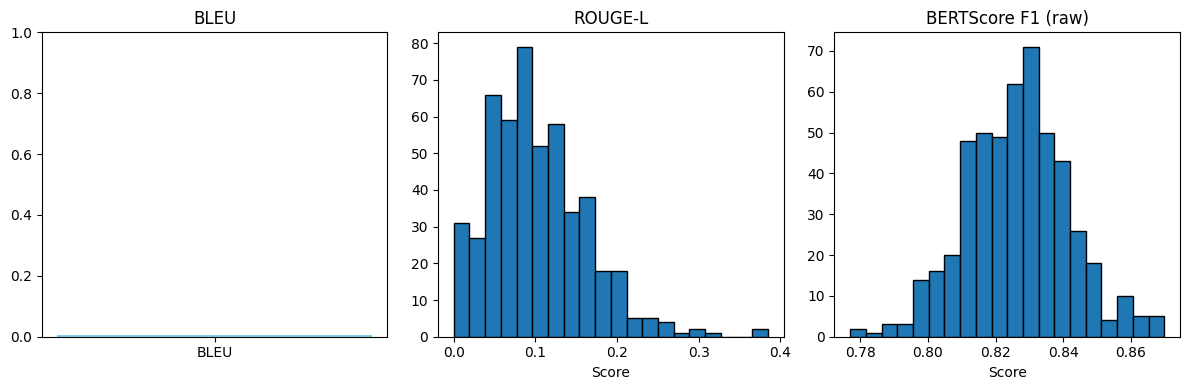

In [ ]:
# Statistics — BLEU, ROUGE-L & BERTScore
import torch, numpy as np, matplotlib.pyplot as plt
from datasets import load_dataset
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from transformers import AutoTokenizer, AutoModelForCausalLM

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = "/content/drive/My Drive/models/dialogpt_empathetic_final_small"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model     = AutoModelForCausalLM.from_pretrained(model_dir).to(device)
model.eval()

# ─── Preparing data ─────────────────────────────────────────────────
ds = load_dataset("empathetic_dialogues", split="test")
small_ds = ds.select(range(500))  # take first 500 examples

pairs = [
    (f"<emotion={item['context']}> {item['prompt']}", item['utterance'])
    for item in small_ds
]
prompts, references = zip(*pairs)
# BLEU expects list of list of token lists
bleu_refs = [[ref.split()] for ref in references]

# ─── Generating replies ──────────────────────────────────────────────
gen_texts = []
for p in prompts:
    enc = tokenizer(p, return_tensors="pt", truncation=True, max_length=128).to(device)
    out = model.generate(
        **enc,
        max_new_tokens=50,
        pad_token_id=tokenizer.eos_token_id
    )
    # only the newly generated tokens
    gen = tokenizer.decode(out[0][enc.input_ids.shape[-1]:],
                           skip_special_tokens=True).strip()
    gen_texts.append(gen)

# ─── Computing BLEU & ROUGE-L ────────────────────────────────────────
smooth     = SmoothingFunction().method1
bleu_score = corpus_bleu(
    bleu_refs,
    [g.split() for g in gen_texts],
    smoothing_function=smooth
)

scorer      = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
rougeL_list = [
    scorer.score(ref, gen)["rougeL"].fmeasure
    for ref, gen in zip(references, gen_texts)
]
avg_rougeL  = np.mean(rougeL_list)

# ─── Computing BERTScore ─────────────────────────────
P, R, F1_raw = bert_score(
    gen_texts,
    list(references),
    lang='en',
    rescale_with_baseline=False
)
avg_bert_f1 = F1_raw.mean().item()

# ─── Displaying results ──────────────────────────────────────────────
print(f"→ BLEU score (corpus):    {bleu_score:.4f}")
print(f"→ ROUGE-L (avg f-measure): {avg_rougeL:.4f}")
print(f"→ BERTScore F1 (raw avg):  {avg_bert_f1:.4f}")

# ─── Plot Distributions ──────────────────────────────────────────
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.bar(["BLEU"], [bleu_score], color='skyblue')
plt.ylim(0,1)
plt.title("BLEU")

plt.subplot(1,3,2)
plt.hist(rougeL_list, bins=20, edgecolor='black')
plt.title("ROUGE-L")
plt.xlabel("Score")

plt.subplot(1,3,3)
plt.hist(F1_raw.cpu().numpy(), bins=20, edgecolor='black')
plt.title("BERTScore F1 (raw)")
plt.xlabel("Score")

plt.tight_layout()
plt.show()